### ノック７１：フォルダ生成をしてデータ読み込みの準備をしよう

In [1]:
# 作業フォルダを準備
import os

data_dir = 'data'
input_dir = os.path.join(data_dir, '0_input')
output_dir = os.path.join(data_dir, '1_output')
master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'

os.makedirs(input_dir,exist_ok=True)
os.makedirs(output_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

### ノック７２：予測したい新規データを読み込もう

In [2]:
# マスタデータの読み込み
import pandas as pd

m_area_file = 'm_area.csv'
m_store_file = 'm_store.csv'

m_area = pd.read_csv(os.path.join(master_dir, m_area_file))
m_store = pd.read_csv(os.path.join(master_dir, m_store_file))

In [3]:
# データの読み込み
tg_ym = "202003"
target_file = "tbl_order_" + tg_ym + ".csv"
target_data = pd.read_csv(os.path.join(input_dir, target_file))


# データのチェックを行う
import datetime

max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()

max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")

if tg_ym == min_str_date and tg_ym == max_str_date:
    print("日付が一致しました")
else:
    raise Exception("日付が一致しません")

日付が一致しました


### ノック７３：新規データを店舗別で集計しよう

In [4]:
# 店舗別に集計するために関数を設定(詳細はノック５１～を参照)

def calc_delta(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/60

def data_processing(order_data):
    order_data = order_data.loc[order_data['store_id'] != 999]
    order_data = pd.merge(order_data, m_store, on='store_id', how='left')
    order_data = pd.merge(order_data, m_area, on='area_cd', how='left')
    order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'デリバリー'
    order_data.loc[order_data['takeout_flag'] == 1, 'takeout_name'] = 'お持ち帰り'
    order_data.loc[order_data['status'] == 0, 'status_name'] = '受付'
    order_data.loc[order_data['status'] == 1, 'status_name'] = 'お支払済'
    order_data.loc[order_data['status'] == 2, 'status_name'] = 'お渡し済'
    order_data.loc[order_data['status'] == 9, 'status_name'] = 'キャンセル'

    order_data.loc[:,'order_accept_datetime'] = pd.to_datetime(order_data['order_accept_date'])
    order_data.loc[:,'delivered_datetime'] = pd.to_datetime(order_data['delivered_date'])
    order_data.loc[:,'delta'] = order_data[['order_accept_datetime', 'delivered_datetime']].apply(calc_delta, axis=1)
    order_data.loc[:,'order_accept_hour'] = order_data['order_accept_datetime'].dt.hour
    order_data.loc[:,'order_accept_weekday'] = order_data['order_accept_datetime'].dt.weekday
    order_data.loc[order_data['order_accept_weekday'] >= 5, 'weekday_info'] = '休日'
    order_data.loc[order_data['order_accept_weekday'] < 5, 'weekday_info'] = '平日'

    store_data = order_data.groupby(['store_name']).count()[['order_id']]
    store_f = order_data.loc[(order_data['status_name']=="お渡し済")|
                             (order_data['status_name']=="お支払済")].groupby(['store_name']).count()[['order_id']]
    store_c = order_data.loc[order_data['status_name']=="キャンセル"].groupby(['store_name']).count()[['order_id']]
    store_d = order_data.loc[order_data['takeout_name']=="デリバリー"].groupby(['store_name']).count()[['order_id']]
    store_t = order_data.loc[order_data['takeout_name']=="お持ち帰り"].groupby(['store_name']).count()[['order_id']]
    store_weekday = order_data.loc[order_data['weekday_info']=="平日"].groupby(['store_name']).count()[['order_id']]
    store_weekend = order_data.loc[order_data['weekday_info']=="休日"].groupby(['store_name']).count()[['order_id']]
    times = order_data['order_accept_hour'].unique()
    store_time = []

    for time in times:
        time_tmp = order_data.loc[order_data['order_accept_hour']==time].groupby(['store_name']).count()[['order_id']]
        time_tmp.columns = [f'order_time_{time}']
        store_time.append(time_tmp)

    store_time = pd.concat(store_time, axis=1)
    store_delta = order_data.loc[order_data['status_name']!="キャンセル"].groupby(['store_name'])[['delta']].mean()
    store_data.columns = ['order']
    store_f.columns = ['order_fin']
    store_c.columns = ['order_cancel']
    store_d.columns = ['order_delivery']
    store_t.columns = ['order_takeout']
    store_delta.columns = ['delta_avg']
    store_weekday.columns = ['order_weekday']
    store_weekend.columns = ['order_weekend']

    store_data = pd.concat([store_data, store_f, store_c, store_d, store_t,
                        store_weekday, store_weekend, store_time, store_delta], axis=1)
    return store_data

In [5]:
# 関数を用いて、店舗別集計の実行
store_data = data_processing(target_data)
store_data.reset_index(drop=False, inplace=True)
actual_data = store_data.copy()

C:\Users\nao23\AppData\Local\Temp\ipykernel_12292\2570458585.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'デリバリー' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'デリバリー'
C:\Users\nao23\AppData\Local\Temp\ipykernel_12292\2570458585.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '受付' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  order_data.loc[order_data['status'] == 0, 'status_name'] = '受付'
C:\Users\nao23\AppData\Local\Temp\ipykernel_12292\2570458585.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '休日' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  order_data.loc[o

In [6]:
actual_data.head(10)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg
0,あきる野店,1186,958,228,858,328,839,347,104,107,109,105,113,103,101,106,113,114,111,35.204593
1,さいたま南店,1553,1266,287,1145,408,1103,450,165,136,140,126,122,150,145,152,151,134,132,35.259084
2,さいたま緑店,1063,875,188,807,256,754,309,113,82,79,93,108,103,94,100,91,96,104,35.268571
3,さいたま西店,1219,977,242,911,308,865,354,107,124,120,91,106,104,111,116,103,110,127,34.294780
4,つくば店,1306,1057,249,976,330,928,378,113,108,120,113,109,123,130,127,125,104,134,34.783349
5,三浦店,1176,975,201,894,282,831,345,114,101,114,108,106,110,92,102,106,100,123,33.807179
6,三鷹店,1542,1257,285,1134,408,1092,450,142,133,146,146,119,144,159,134,147,134,138,34.533811
7,上尾店,1369,1159,210,1014,355,972,397,128,124,105,142,138,116,118,113,118,136,131,20.433995
8,上野店,1681,1386,295,1263,418,1197,484,152,157,145,164,130,141,156,164,156,166,150,34.606061
9,世田谷店,1579,1267,312,1173,406,1120,459,148,140,151,133,147,144,149,139,145,120,163,34.679558


### ノック７４：新規データのカテゴリカル変数対応をしよう

In [7]:
# カテゴリカル変数の対応
category_data = pd.get_dummies(store_data['store_name'], prefix='store' ,prefix_sep='_')

# ノック６１～の時と異なり、year_month と store_name は削除する記述は無い。
# 今回はyear_month列が無いのと、後で X_cols.csvを用いて説明変数を抽出するため
del category_data['store_麻生店']

store_data = pd.concat([store_data, category_data],axis=1)
store_data.head(3)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,あきる野店,1186,958,228,858,328,839,347,104,107,...,False,False,False,False,False,False,False,False,False,False
1,さいたま南店,1553,1266,287,1145,408,1103,450,165,136,...,False,False,False,False,False,False,False,False,False,False
2,さいたま緑店,1063,875,188,807,256,754,309,113,82,...,False,False,False,False,False,False,False,False,False,False


### ノック７５：モデルに投入する直前の形式に整えよう

In [8]:
# 説明変数の設定
X_cols_name = 'X_cols.csv'
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols['X_cols']

In [9]:
X_cols

0               order
1           order_fin
2        order_cancel
3      order_delivery
4       order_takeout
            ...      
208         store_高座店
209         store_高津店
210       store_高田馬場店
211         store_鴻巣店
212         store_鶴見店
Name: X_cols, Length: 213, dtype: object

In [10]:
X = store_data[X_cols].copy()
X.head(3)

,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,1186,958,228,858,328,839,347,104,107,109,...,False,False,False,False,False,False,False,False,False,False
1,1553,1266,287,1145,408,1103,450,165,136,140,...,False,False,False,False,False,False,False,False,False,False
2,1063,875,188,807,256,754,309,113,82,79,...,False,False,False,False,False,False,False,False,False,False


### ノック７６：モデルファイルを読み込んでみよう

In [11]:
# 平日モデルと休日モデルを読み込む
import pickle

model_weekday_name = 'model_y_weekday_GradientBoosting.pickle'
model_weekend_name = 'model_y_weekend_GradientBoosting.pickle'

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode='rb') as f:
    model_weekday = pickle.load(f)

with open(model_weekend_path, mode='rb') as f:
    model_weekend = pickle.load(f)

# printすると、モデル構築をした際のパラメータ情報を出力する
print(model_weekday)
print(model_weekend)

GradientBoostingClassifier(random_state=0)
GradientBoostingClassifier(random_state=0)


### ノック７７：新規データの予測をしてみよう

In [12]:
# 予測を実施
pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)
pred_weekend[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [13]:
# 確立を出力するメソッドで再出力
# 左が0の確立、右が1の確立
pred_proba_weekday = model_weekday.predict_proba(X)
pred_proba_weekend = model_weekend.predict_proba(X)
pred_proba_weekend[:10]

array([[0.71866699, 0.28133301],
       [0.61231504, 0.38768496],
       [0.53604944, 0.46395056],
       [0.77746324, 0.22253676],
       [0.59048016, 0.40951984],
       [0.80779612, 0.19220388],
       [0.79061865, 0.20938135],
       [0.70969261, 0.29030739],
       [0.31063937, 0.68936063],
       [0.84098724, 0.15901276]])

In [14]:
# 1の確立だけ抽出
pred_proba_weekday = pred_proba_weekday[:,1]
pred_proba_weekend = pred_proba_weekend[:,1]
pred_proba_weekend[:10]

array([0.28133301, 0.38768496, 0.46395056, 0.22253676, 0.40951984,
       0.19220388, 0.20938135, 0.29030739, 0.68936063, 0.15901276])

In [15]:
# dataframeとして保存
pred = pd.DataFrame({'pred_weekday':pred_weekday, 'pred_weekend':pred_weekend,
                     'score_weekday':pred_proba_weekday, 'score_weekend':pred_proba_weekend})

# 補足データを付与。推測結果と順番が同じ事が分かっているため、そのまま付与
pred.loc[:,'store_name'] = store_data['store_name']
pred.loc[:,'year_month'] = tg_ym
pred.head(3)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0,0.0,0.769104,0.281333,あきる野店,202003
1,1.0,0.0,0.677146,0.387685,さいたま南店,202003
2,1.0,0.0,0.842885,0.463951,さいたま緑店,202003


### ノック７８：予測結果のヒートマップを作成してみよう

In [16]:
# ヒートマップ用のデータを作成
pred_viz = pred[['store_name','score_weekday','score_weekend']].copy()
pred_viz.set_index('store_name', inplace=True)
pred_viz

,score_weekday,score_weekend
store_name,,
あきる野店,0.769104,0.281333
さいたま南店,0.677146,0.387685
さいたま緑店,0.842885,0.463951
さいたま西店,0.690989,0.222537
つくば店,0.718913,0.409520
...,...,...
高津店,0.859683,0.328371
高田馬場店,0.602432,0.518836
鴻巣店,0.748131,0.318636


<Axes: xlabel='store_name'>

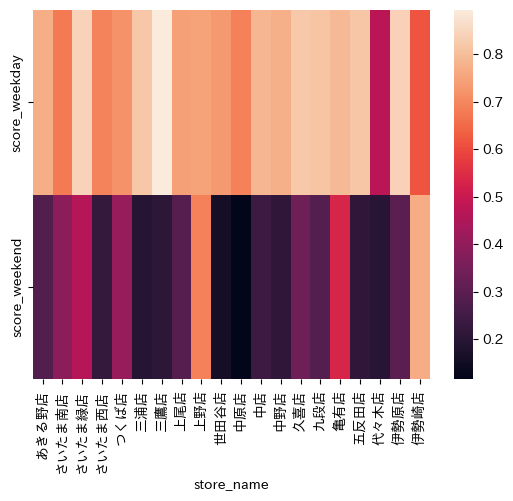

In [17]:
# 可視化する
import seaborn as sns
import japanize_matplotlib

japanize_matplotlib.japanize()
sns.heatmap(pred_viz[:20].T)

### ノック７９：実績データを作成しよう

In [18]:
# 実績データの作成
target_cols = ['store_name', 'order', 'order_fin', 'order_cancel', 'order_delivery',
       'order_takeout', 'order_weekday', 'order_weekend', 'delta_avg']

actual_data = actual_data[target_cols]
actual_cols = ['store_name']
rename_cols = [x + f'_{tg_ym}' for x in actual_data.columns if x != 'store_name']

actual_cols.extend(rename_cols)
actual_data.columns = actual_cols
actual_data.head(3)

,store_name,order_202003,order_fin_202003,order_cancel_202003,order_delivery_202003,order_takeout_202003,order_weekday_202003,order_weekend_202003,delta_avg_202003
0,あきる野店,1186,958,228,858,328,839,347,35.204593
1,さいたま南店,1553,1266,287,1145,408,1103,450,35.259084
2,さいたま緑店,1063,875,188,807,256,754,309,35.268571


### ノック８０：現場に向けたレポートを作成し出力しよう

In [19]:
# scoreの簡易化
pred.loc[pred['score_weekday'] >= 0.75,'オーダー予測 平日'] = '増加大'
pred.loc[(pred['score_weekday'] < 0.75)&(pred['score_weekday'] >= 0.5),'オーダー予測 平日'] = '増加'
pred.loc[(pred['score_weekday'] < 0.5)&(pred['score_weekday'] >= 0.25),'オーダー予測 平日'] = '減少'
pred.loc[pred['score_weekday'] < 0.25,'オーダー予測 平日'] = '減少大'

pred.loc[pred['score_weekend'] >= 0.75,'オーダー予測 休日'] = '増加大'
pred.loc[(pred['score_weekend'] < 0.75)&(pred['score_weekend'] >= 0.5),'オーダー予測 休日'] = '増加'
pred.loc[(pred['score_weekend'] < 0.5)&(pred['score_weekend'] >= 0.25),'オーダー予測 休日'] = '減少'
pred.loc[pred['score_weekend'] < 0.25,'オーダー予測 休日'] = '減少大'

C:\Users\nao23\AppData\Local\Temp\ipykernel_12292\3055269792.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '増加大' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pred.loc[pred['score_weekday'] >= 0.75,'オーダー予測 平日'] = '増加大'
C:\Users\nao23\AppData\Local\Temp\ipykernel_12292\3055269792.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '増加大' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pred.loc[pred['score_weekend'] >= 0.75,'オーダー予測 休日'] = '増加大'


In [20]:
# 実績データを結合
report = pred[['store_name','オーダー予測 平日','オーダー予測 休日', 'score_weekday', 'score_weekend']]
report = pd.merge(report, actual_data , on='store_name', how='left')
report.head(3)

,store_name,オーダー予測 平日,オーダー予測 休日,score_weekday,score_weekend,order_202003,order_fin_202003,order_cancel_202003,order_delivery_202003,order_takeout_202003,order_weekday_202003,order_weekend_202003,delta_avg_202003
0,あきる野店,増加大,減少,0.769104,0.281333,1186,958,228,858,328,839,347,35.204593
1,さいたま南店,増加,減少,0.677146,0.387685,1553,1266,287,1145,408,1103,450,35.259084
2,さいたま緑店,増加大,減少,0.842885,0.463951,1063,875,188,807,256,754,309,35.268571


In [21]:
# 現場向けレポートの出力
pred_ym = datetime.datetime.strptime(tg_ym, '%Y%m')
from dateutil.relativedelta import relativedelta
pred_ym = pred_ym + relativedelta(months=1)
pred_ym = datetime.datetime.strftime(pred_ym, '%Y%m')

report_name = f'report_pred_{pred_ym}.xlsx'
report.to_excel(os.path.join(output_dir, report_name), index=False)